In [1]:
# check here for updated maps
# https://www.arcgis.com/home/user.html?user=brad.duplantis_cor

# process tree_inventory.json
# from https://services1.arcgis.com/k3vhq11XkBNeeOfM/arcgis/rest/services/UFInventory2019Jan10/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryPoint&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=species%2C+condition%2C+address%2C+treeid&returnGeometry=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=html&token=
# with Out Fields =  SPP, COND, AddrLabl, TreeID

# 2020-

In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

import colorcet as cc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


In [2]:
df = pd.read_csv('tree_inventory_20201118.csv').drop(columns='Unnamed: 0')

In [3]:
df.head()

species condition                  addr   treeid  objid  \
0    Quercus phellos      Fair  3315 Chimborazo Park  57491.0      1   
1         Malus spp.      Good         801 N 23rd St  58095.0      2   
2  Cercis canadensis      Good         801 N 23rd St  58096.0      3   
3         Malus spp.      Good         805 N 23rd St  58097.0      4   
4              Stump     Stump          2020 2nd Ave  58098.0      5   

          geo_x         geo_y  
0  1.179866e+07  3.716462e+06  
1  1.179712e+07  3.720919e+06  
2  1.179714e+07  3.720949e+06  
3  1.179716e+07  3.720979e+06  
4  1.179440e+07  3.729826e+06

In [5]:
# aggregate counts of tree species
spct = df.groupby('species').count().sort_values('objid', ascending=False).reset_index()[['species','objid']]
spct.columns = ['species','scount']
spct = spct[~spct['species'].str.contains('Vacant')]
spct = spct[~spct['species'].str.contains('Stump')]
spct['perc'] = spct.scount / spct.scount.sum() * 100
spct = spct.set_index('species')
spct.head(10)

scount      perc
species                                  
Lagerstroemia indica       7486  9.898843
Acer saccharum             6079  8.038347
Acer rubrum                4906  6.487273
Quercus phellos            4882  6.455537
Zelkova serrata            4033  5.332893
Quercus palustris          3282  4.339835
Ulmus alata                2666  3.525289
Pinus taeda                2224  2.940826
Liquidambar styraciflua    1943  2.569256
Prunus spp.                1824  2.411901

In [6]:
spct.to_csv('top_trees.csv')

In [4]:
# plotting coordinates - 
# this is using a Coordinate Reference System (CRS) where the coordinates are relative to a fixed reference.
# if we look at data.spatial_reference in the ArcGIS json, we see the wkid is 102747 - https://spatialreference.org/ref/esri/102747/html/
# that's crs="ESRI:102747"
# actually latestwkid = 2284 works better - https://spatialreference.org/ref/epsg/2284/
# crs="EPSG:2284"

df['geometry'] = df.apply(lambda x: Point(x.geo_x,x.geo_y), 1)

gdf = gpd.GeoDataFrame(df, crs="EPSG:2284")

In [12]:
import fiona
# verify available save file formats
#fiona.supported_drivers

In [11]:
# save to a shapefile for portability
gdf.to_file(driver = 'ESRI Shapefile', filename="shapefile/tree_inventory_20201118.shp")

In [10]:

# for the background (base layer), I'm just loading the road shapes. there's a bunch of other options
# From Richmond GIS FTP - ftp://ftp.ci.richmond.va.us/GIS/Shapefiles/Basemap/
rvaroads = gpd.read_file('Basemap/base_Road.shp')


In [11]:
species = ['Lagerstroemia indica','Acer saccharum','Acer rubrum','Quercus phellos','Zelkova serrata','Quercus palustris','Ulmus alata','Pinus taeda','Liquidambar styraciflua','Prunus spp.']

# count of trees in the top 10 species list
#gdf[~gdf['species'].isin(species)].count()

# count of vacant sites
#gdf[gdf['species'].str.contains('Vacant') | gdf['species'].str.contains('Stump')].count()

# total count
gdf.count()

# 39325 in the top 10 species list
# 44819 empty / vacant / stump
# 36300 not in top 10
# 120453 total (includes like 9 null species records)

species      120444
condition    120453
addr         120444
treeid       120442
objid        120453
geo_x        120453
geo_y        120453
geometry     120453
dtype: int64

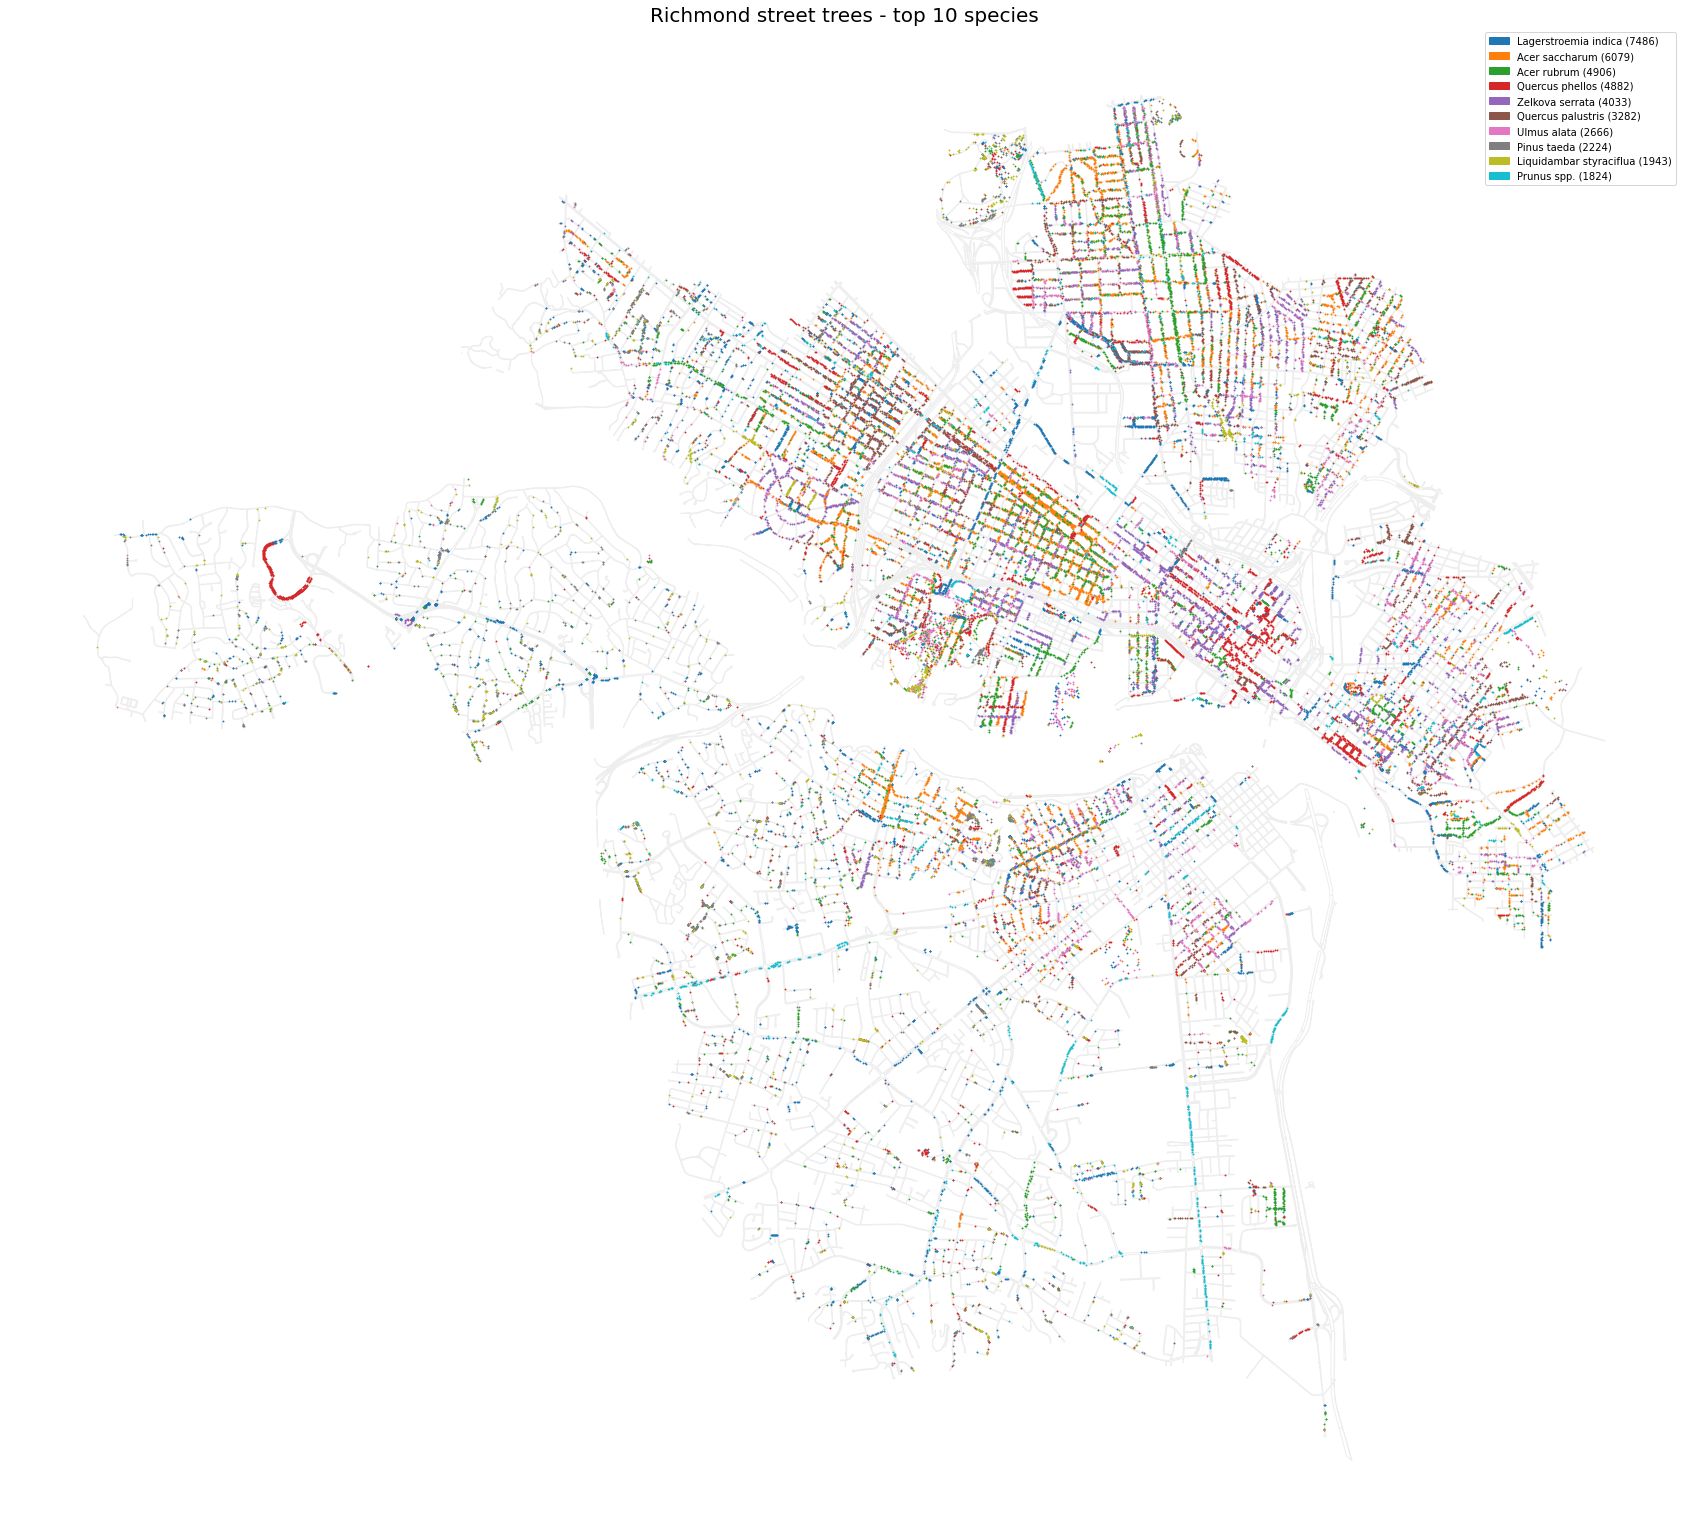

In [12]:
# plot the top 10

fig = plt.figure(figsize=(30,30)) # controls resolution - figure size in inches
ax = fig.add_subplot()

# plot a base layer
rvaroads.plot(ax=ax, color='white', edgecolor='#eeeeee')

splots = []
# We can now plot our top geodataframe
# had to loop and plot one species at a time to get better control of the colors
for (i,s) in enumerate(species):
    # plot this species
    gdf[gdf['species']==s].plot(ax=ax, color=cc.glasbey_category10[i], marker='*', markersize=1)
    
    # create a proxy label for each species (to show a nice legend)
    splots.append(mpatches.Patch(color=cc.glasbey_category10[i], 
                                 label='{} ({:1.0f})'.format(s, 
                                                             spct.loc[s,['scount']].values[0])))

ax.set_title('Richmond street trees - top 10 species', fontsize=20)
plt.legend(handles=splots)

plt.axis('off')

#plt.show(fig)
plt.savefig("pics/top10.png", facecolor='white', bbox_inches='tight')

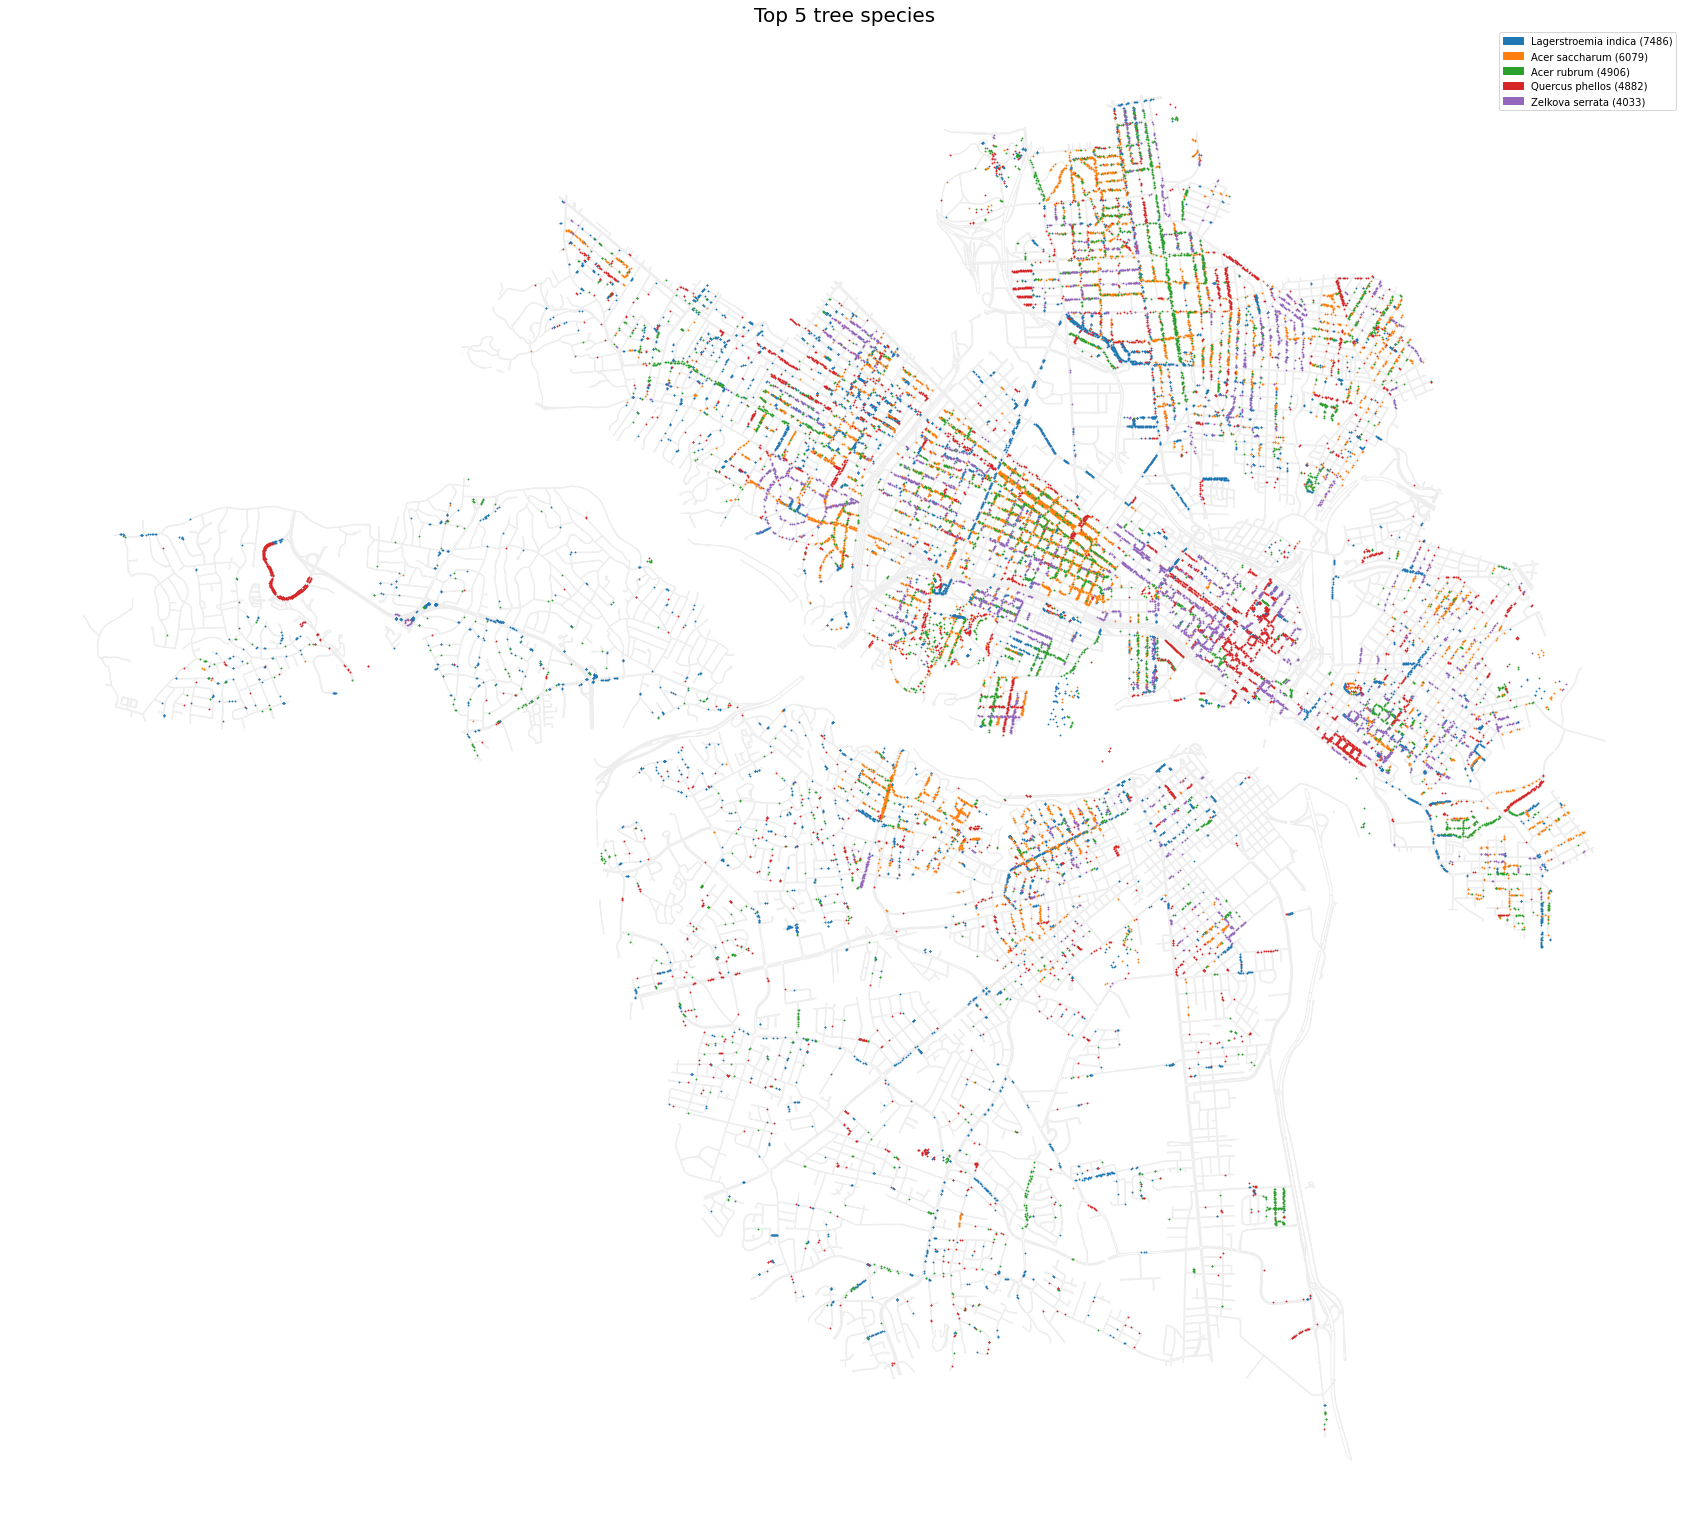

In [13]:
# just top 5

species = ['Lagerstroemia indica','Acer saccharum','Acer rubrum','Quercus phellos','Zelkova serrata']

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot()

# plot a base layer
rvaroads.plot(ax=ax, color='white', edgecolor='#eeeeee')

splots = []
# We can now plot our top geodataframe
for (i,s) in enumerate(species):
    gdf[gdf['species']==s].plot(ax=ax, color=cc.glasbey_category10[i], marker='*', markersize=1)
    splots.append(mpatches.Patch(color=cc.glasbey_category10[i], 
                                 label='{} ({:1.0f})'.format(s, 
                                                             spct.loc[s,['scount']].values[0])))

ax.set_title('Top 5 tree species', fontsize=20)
plt.legend(handles=splots)

plt.axis('off')

#plt.show(fig)
plt.savefig("pics/top5.png", facecolor='white', bbox_inches='tight')

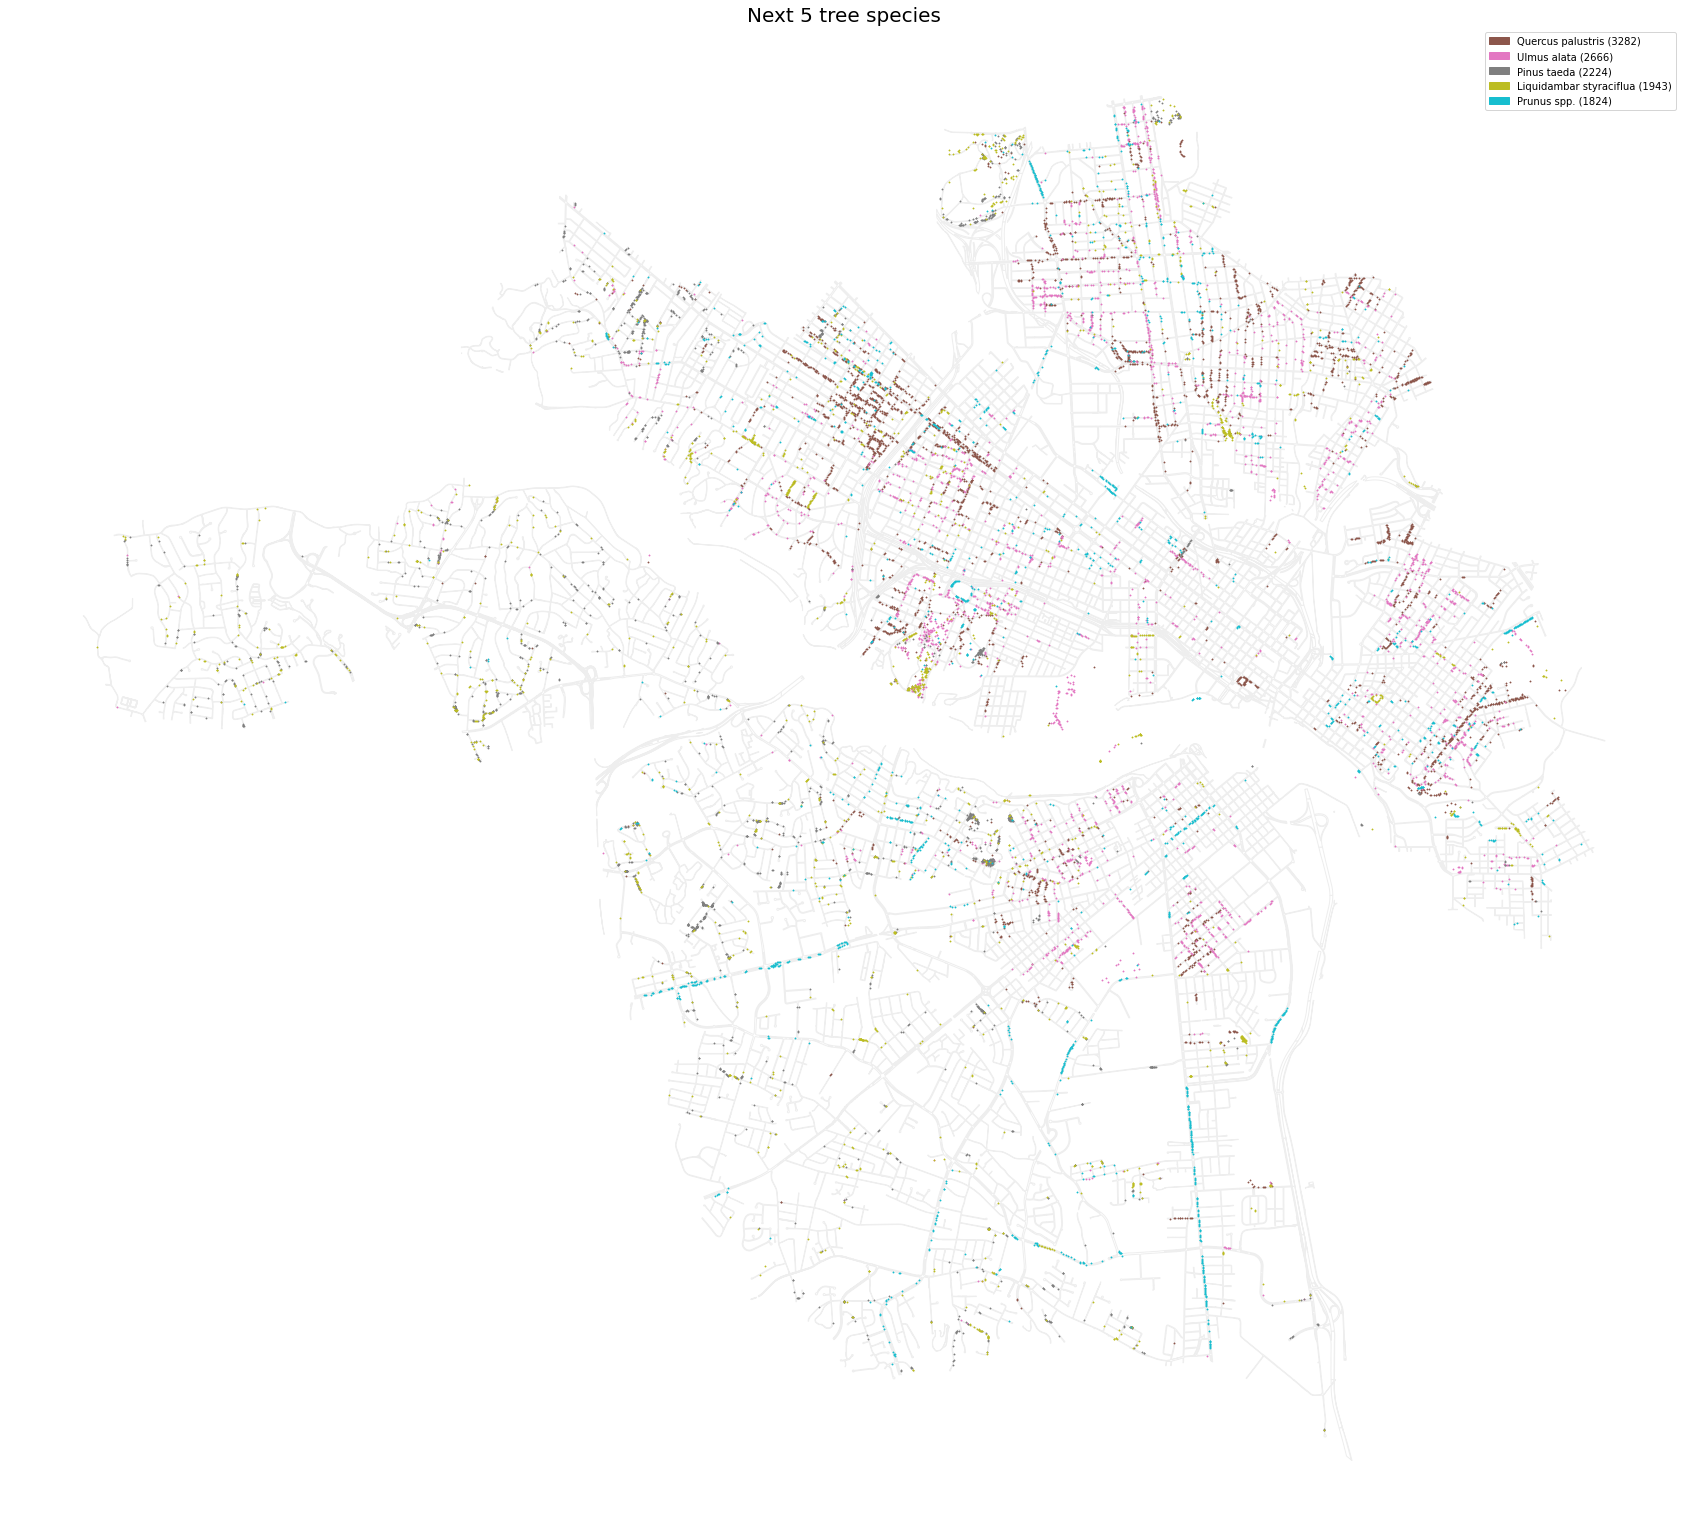

In [14]:
# next 5

species = ['Quercus palustris','Ulmus alata','Pinus taeda','Liquidambar styraciflua','Prunus spp.']
gdf_mini = gdf[gdf['species'].isin(species)]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot()

# plot a base layer
rvaroads.plot(ax=ax, color='white', edgecolor='#eeeeee')

splots = []
# We can now plot our top geodataframe
for (i,s) in enumerate(species): # note that we pick color "5+i" to start where we left off from the top5
    gdf[gdf['species']==s].plot(ax=ax, color=cc.glasbey_category10[5+i], marker='*', markersize=1)
    splots.append(mpatches.Patch(color=cc.glasbey_category10[5+i], 
                                 label='{} ({:1.0f})'.format(s, 
                                                             spct.loc[s,['scount']].values[0])))
plt.legend(handles=splots)

ax.set_title('Next 5 tree species', fontsize=20)

plt.axis('off')

plt.savefig("pics/next5.png", facecolor='white', bbox_inches='tight')
plt.show(fig)

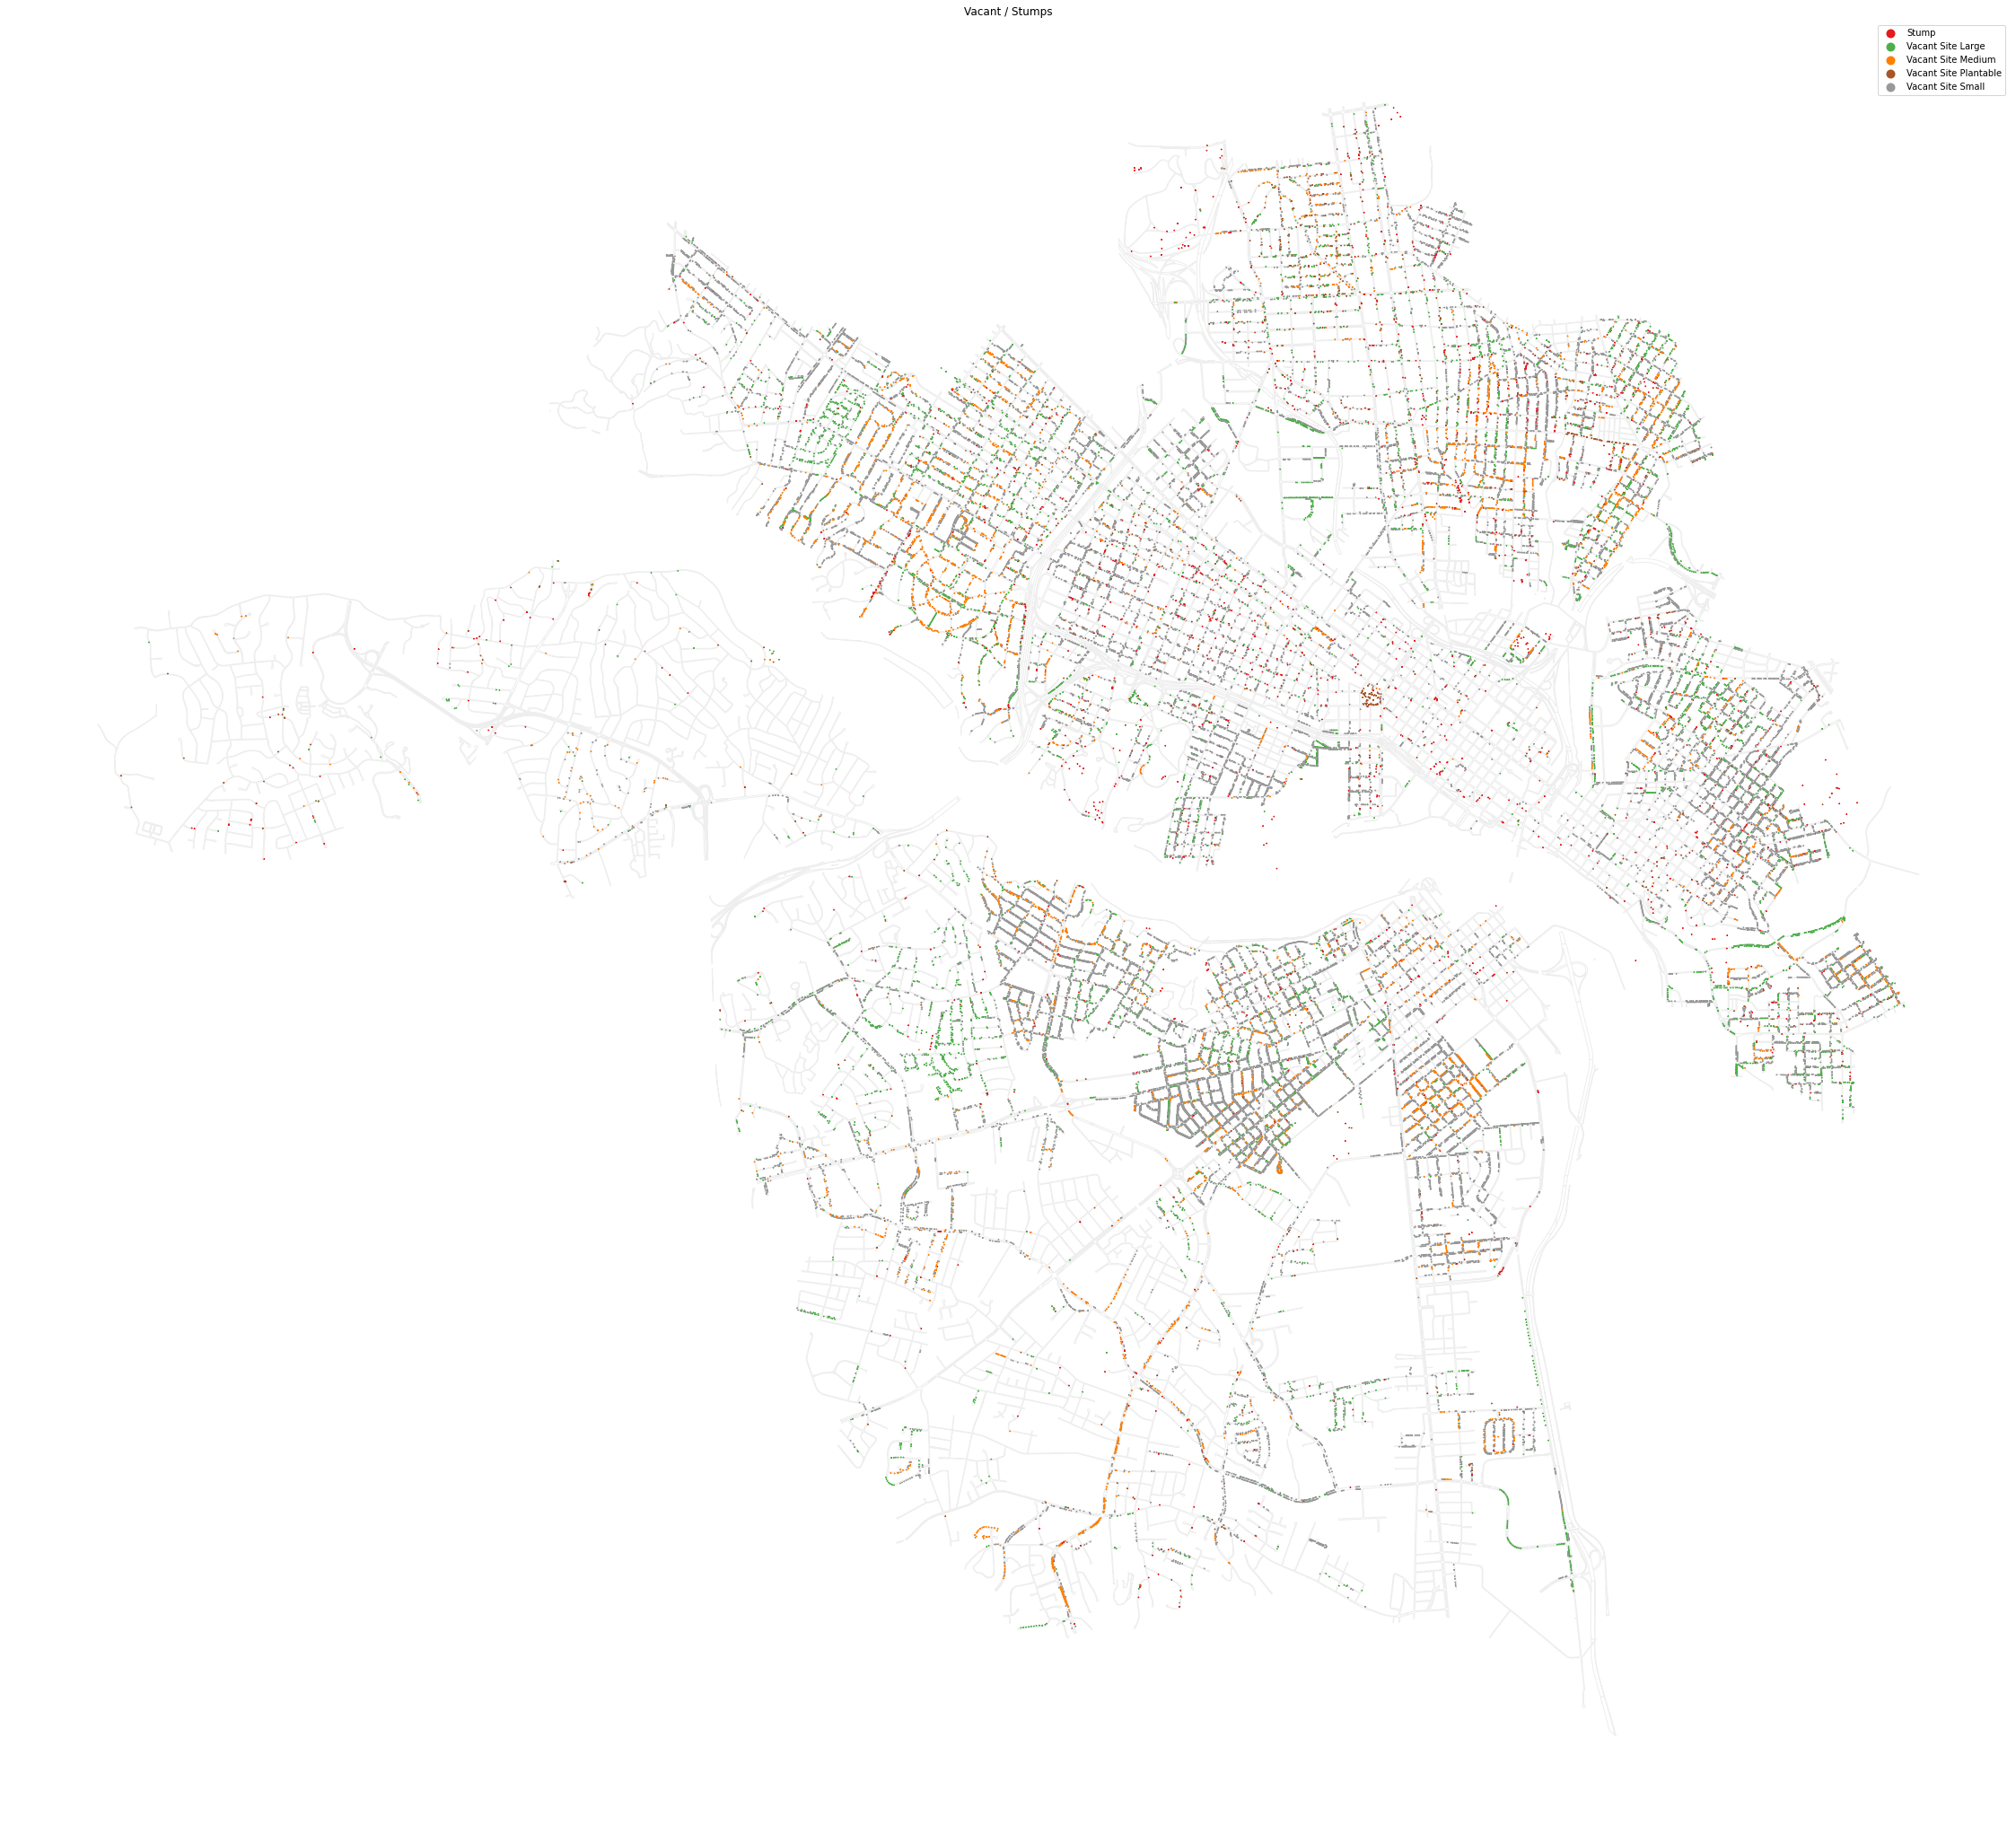

In [15]:
# Vacant sites / stumps

fig = plt.figure(figsize=(40,40))
ax = fig.add_subplot()

# plot a base layer
rvaroads.plot(ax=ax, color='white', edgecolor='#eeeeee')

# We can now plot our top geodataframe
gdf[gdf['species'].str.contains('Vacant') | gdf['species'].str.contains('Stump')].plot(ax=ax, column='species', cmap='Set1', marker='*', markersize=1, legend=True)

ax.set_title('Vacant / Stumps')

plt.axis('off')

plt.savefig("pics/vacant.png", facecolor='white', bbox_inches='tight')
plt.show(fig)

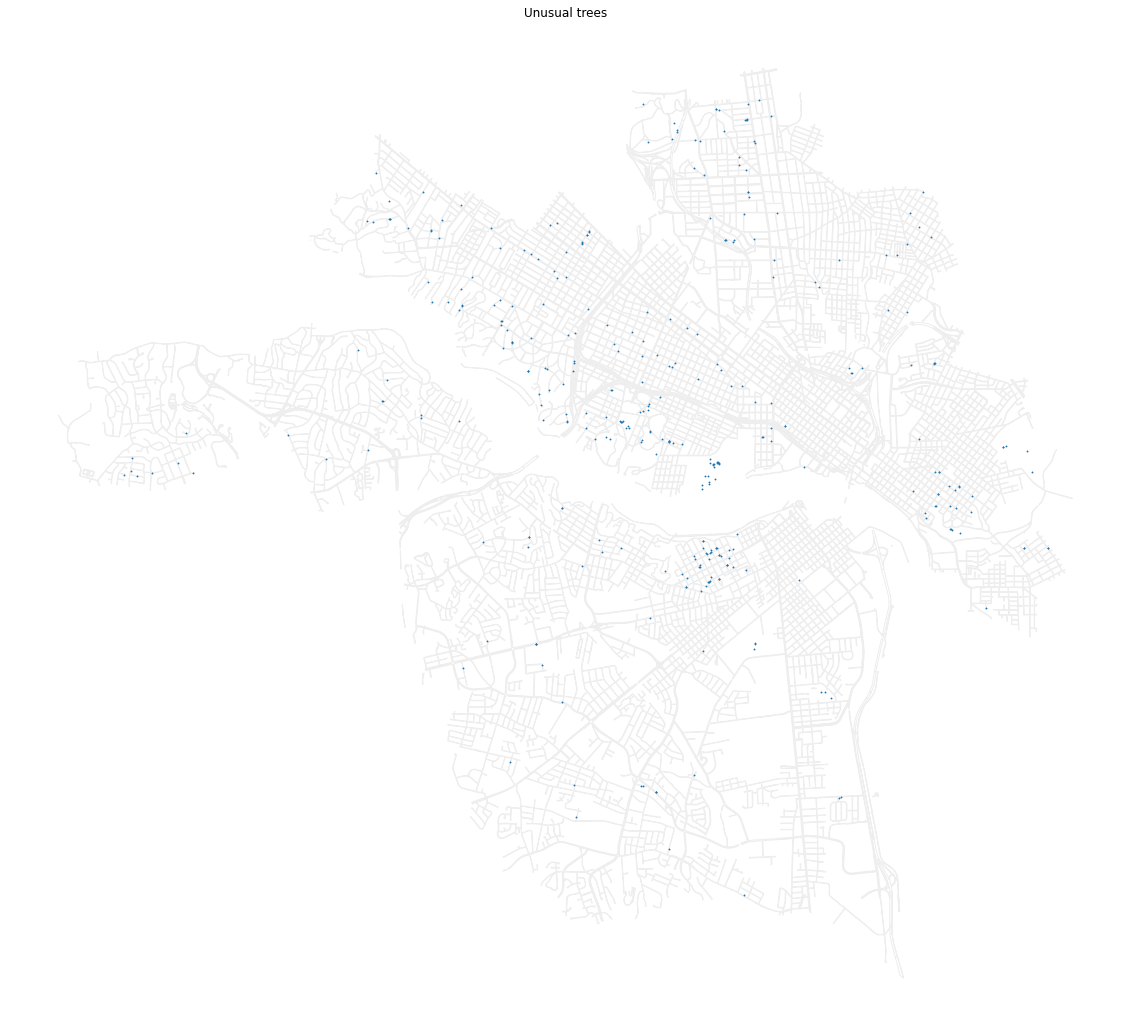

In [16]:

# plot uncommon tree species - with 10 or less instances

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()

# plot a base layer
rvaroads.plot(ax=ax, color='white', edgecolor='#eeeeee')

# We can now plot our top geodataframe
gdf[gdf['species'].isin(spct[spct['scount']<=10].index)].plot(ax=ax, marker='*', markersize=1)

ax.set_title('Unusual trees')

plt.axis('off')

plt.show(fig)

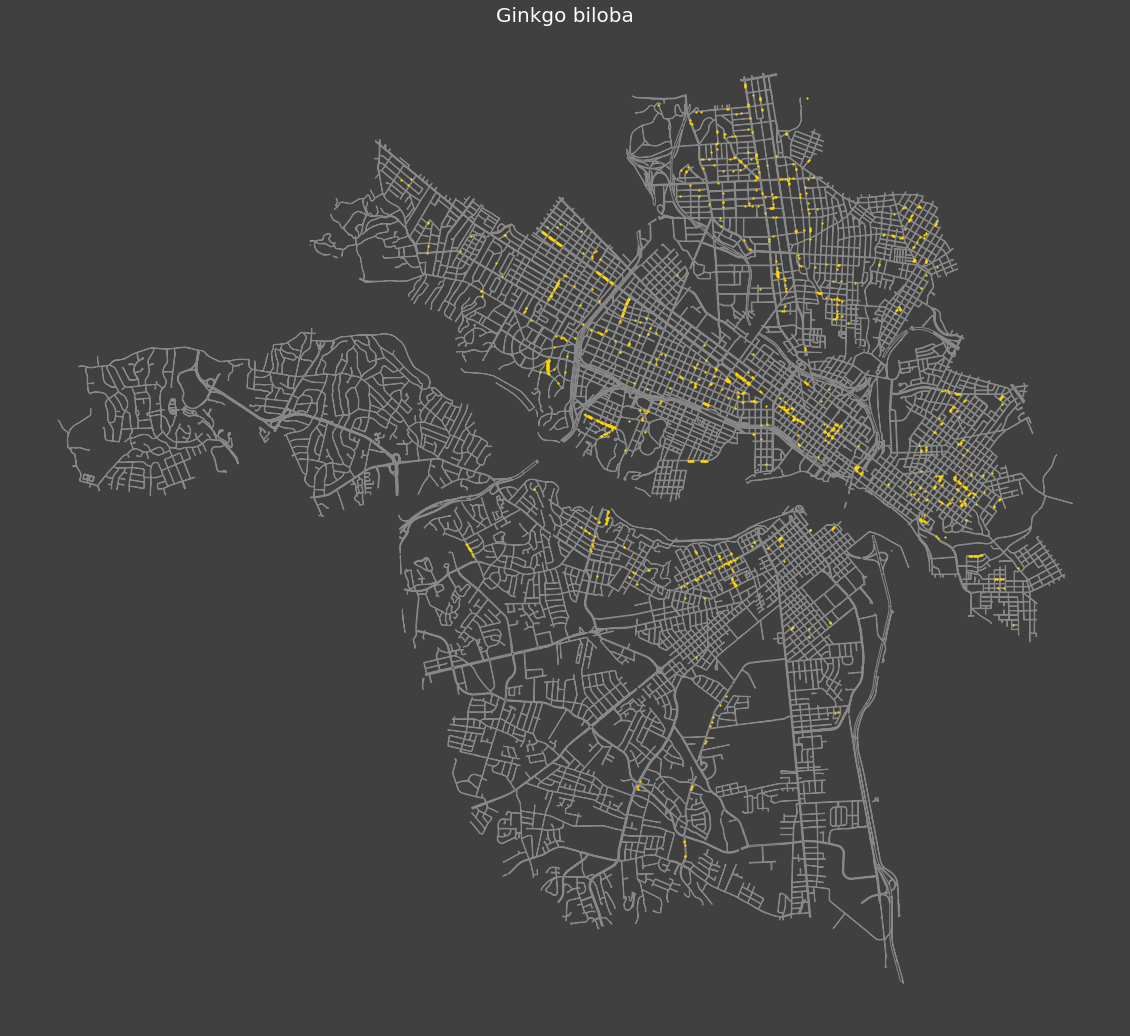

In [17]:
# just plot one species at a time

# trying a dark background so the gold for ginkgo will look nice

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()

# plot a base layer
rvaroads.plot(ax=ax, color='#404040', edgecolor='#888888')

# We can now plot our top geodataframe
gdf[gdf['species']=='Ginkgo biloba'].plot(ax=ax, marker='o', markersize=1.5, color="gold")

ax.set_title('Ginkgo biloba', fontsize=20, color="white")
fig.set_facecolor('#404040')

plt.axis('off')

plt.show(fig)

# can just right-click and save